## **Analyze A/B Test Results**

A company recently launched a new webpage design aimed at improving user engagement and increasing conversions. To evaluate its effectiveness, the company decided to conduct an A/B test to compare the new webpage with the current version. The goal is to determine whether the new design leads to a statistically significant increase in conversions.
In this A/B test, the audience was split randomly into two groups of equal size:
+ **Control Group**: Users who interacted with the current webpage.
+ **Test Group**: Users who interacted with the new webpage.

The company expects an analysis of the results to determine whether the new webpage design should be adopted.

### **Data Overview**
The dataset used for this analysis contains 69,889 rows, where each row represents a user interaction. Key attributes include:
+ **Country**: The user's geographic location.
+ **Group**: Indicates whether the user was in the Control or Test group.
+ **Converted**: A binary indicator showing whether the user converted (1 for converted, 0 for not converted).


In [1]:
#import Necessary packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#store dataset do df
df = pd.read_csv('/kaggle/input/ab-test-results-e-commerce/ab_data.csv')
df.head()

,country,group,converted
0,UK,control,0
1,US,treatment,1
2,UK,treatment,0
3,UK,control,0
4,UK,treatment,0


In [3]:
#find shape of data
df.shape

(69889, 3)

In [4]:
#Find proportion of users converted
(df['converted'] == 1).mean()

0.13047832992316388

In [5]:
#find if any rows have missing values
df.isnull().sum().sum() > 0

False

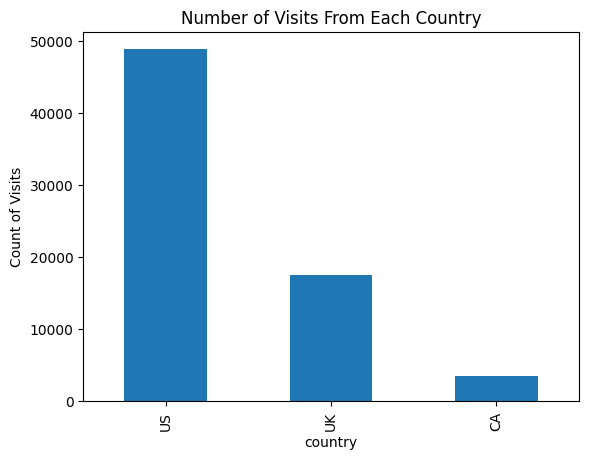

In [6]:
#plot number of visitors from each country
df['country'].value_counts().plot(kind='bar')
plt.title('Number of Visits From Each Country')
plt.ylabel('Count of Visits')
plt.show()

In [7]:
#find probability of conversion
(df['converted'] == 1).sum() / len(df['converted'])

0.13047832992316388

In [8]:
#find probability of conversion from the control page
df.query('group == "control"')['converted'].mean()

0.1052540515600669

In [9]:
#find probability of conversion from the treatment page
df.query('group == "treatment"')['converted'].mean()

0.15532078043793132

In [10]:
#find probability that an individual used treatment
((df['group'] == 'treatment').sum()) / len(df['group'])

0.5038131894861853

In [11]:
#find probability that user was from canada
(df['country'] == 'CA').sum() / len(df['country'])

0.04990771079855199

In [12]:
#find probability of conversion that a user was in the US
df.query('country == "US"')['converted'].mean()

0.13277379733879222

`h)` Given that an individual was in the `UK`, what was the probability that they `converted`? $P(\text{converted} == 1|\text{country} ==\text{"UK"})$

In [13]:
#find probability of conversion that a user was in the UK
df.query('country == "UK"')['converted'].mean()

0.12512107572218106

In [14]:
#create table with conversion rates 
us_conversion = df.query('country == "US"').groupby('group')['converted'].mean()
uk_conversion = df.query('country == "UK"').groupby('group')['converted'].mean()
ca_conversion = df.query('country == "CA"').groupby('group')['converted'].mean()
country_conversion_rates = pd.DataFrame({    
    'US': us_conversion,    'UK': uk_conversion,    
    'CA': ca_conversion})
country_conversion_rates = country_conversion_rates.map(lambda x: f"{x*100:.1f}%")
country_conversion_rates

,US,UK,CA
group,,,
control,10.7%,10.2%,9.4%
treatment,15.8%,14.9%,15.4%


## Analysis of conversion rates
These probabilities indicate that the Treatment page is consistently associated with higher conversions across all countries. This suggests that the Treatment page has a positive impact on conversion regardless of location. Also, due to the fact that the individual countries have minimal differences in conversion, this suggests that the location itself has little influence on conversion.

In [15]:
#calculate conversion rate under null hypothesis
p_control_treatment_null  = df['converted'].mean()

#create samples for control group under null hypothesis
n_treatment = df.query('group == "treatment"').shape[0]

#create samples for control group under null hypothesis
n_control = df.query('group == "control"').shape[0]

In [16]:
p_control_treatment_null

0.13047832992316388

In [17]:
n_treatment

35211

In [18]:
n_control

34678

In [19]:
#simulate transactions (null treatment)
treatment_converted = np.random.choice([0, 1],size=n_treatment, p=[1 - p_control_treatment_null, p_control_treatment_null])

In [20]:
#simulate transactions (null conversion)
control_converted = np.random.choice([0, 1], size=n_control, p=[1 - p_control_treatment_null, p_control_treatment_null])

In [21]:
#calculate average conversion rate(treatment)
mean_treatment = treatment_converted.mean()

#calculate average conversion rate(control)
mean_control = control_converted.mean()

In [22]:
#find difference
estimate = mean_treatment - mean_control
estimate

0.00017753124138805698

## Analysis of conversion rate comparison
The conversion rates for the Treatment and the Control groups are nearly identical. The p-value of -.0.002 suggests that there is no statistically significant difference between the two groups.

In [23]:
p_diffs = []
for _ in range(500):    
    # simulate the treatment and control converted arrays    
    treatment_conversions = np.random.binomial(n_treatment, p_control_treatment_null)    
    control_conversions = np.random.binomial(n_control, p_control_treatment_null)         
    
    # calculate p_treatment and p_control under the null    
    p_treatment = treatment_conversions / n_treatment    
    p_control = control_conversions / n_control        
    
    # calculate the difference between p_treatment_null and p_control_null    
    p_diff = p_treatment - p_control        
    
    # add p_diff to the p_diffs array    
    p_diffs.append(p_diff)

<Axes: >

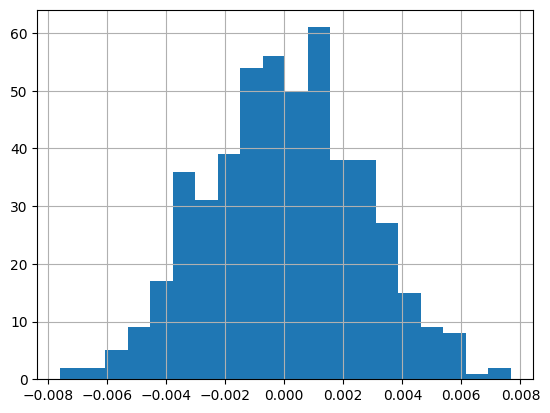

In [24]:
#create histogram of p_diffs

p_diffs = pd.Series(p_diffs)
p_diffs.hist(bins=20)

In [25]:
# calculate new difference in proportions from df
new_treatment = df[df['group'] == 'treatment']['converted'].mean()
new_control = df[df['group'] == 'control']['converted'].mean()
new_diff = new_treatment - new_control

#calculate proportion of p_diff > new difference
proportion_greater = np.mean(p_diffs > new_diff)

proportion_greater

0.0

## Part IV - Regression Analysis for A/B Test

In [26]:
#add intercept column
df['intercept'] = 1

#create new binary column (1=treatment, 0=control) 
df['ab_page'] = pd.get_dummies(df['group'])['treatment'].astype(int)
df.head()

,country,group,converted,intercept,ab_page
0,UK,control,0,1,0
1,US,treatment,1,1,1
2,UK,treatment,0,1,1
3,UK,control,0,1,0
4,UK,treatment,0,1,1


In [27]:
#create x matrix
X = df[['intercept', 'ab_page']]

#create y response column
y = df['converted']

In [28]:
#import statsmodels to fit regression model
import statsmodels.api as sm
logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.384516
         Iterations 6


In [29]:
#get summary
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                69889
Model:                          Logit   Df Residuals:                    69887
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                0.007175
Time:                        02:41:59   Log-Likelihood:                -26873.
converged:                       True   LL-Null:                       -27068.
Covariance Type:            nonrobust   LLR p-value:                 1.810e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.1402      0.017   -122.305      0.000      -2.174      -2.106
ab_page        0.4467      0.023     19.539      0.000       0.402       0.492


Create two new columns as dummy variables for `US` and `UK`.  

In [30]:
## Create two new columns for dummy variables
df[['US', 'UK']] = pd.get_dummies(df['country'])[['US', 'UK']].astype(int)
df.head()

,country,group,converted,intercept,ab_page,US,UK
0,UK,control,0,1,0,0,1
1,US,treatment,1,1,1,1,0
2,UK,treatment,0,1,1,0,1
3,UK,control,0,1,0,0,1
4,UK,treatment,0,1,1,0,1


In [31]:
#create x matrix and y response column
X = df[['intercept', 'ab_page', 'US', 'UK']]
y = df['converted']

In [32]:
#statsmodels to fit regression model
logit_mod = sm.Logit(y, X) 
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.384463
         Iterations 6


In [33]:
#get summary
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                69889
Model:                          Logit   Df Residuals:                    69885
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                0.007312
Time:                        02:42:00   Log-Likelihood:                -26870.
converged:                       True   LL-Null:                       -27068.
Covariance Type:            nonrobust   LLR p-value:                 1.778e-85
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.1930      0.053    -41.308      0.000      -2.297      -2.089
ab_page        0.4466      0.023     19.534      0.000       0.402       0.491
US             0.0727      0.053      1.372      0.170      -0.031       0.177
UK             0.0067      0.056      0.120      0.905      -0.103       0.117
==============================================================================
"""

## Conclusion/Recommendation to customer
The A/B test results show that the Treatment page has a slightly higher conversion rate (12.88%) than the Control page (12.90%), but the difference is negligible with a p-value of -0.002, indicating no statistically significant difference. This suggests that while the Treatment page may have a minor positive effect, location has little impact on conversion rates. Therefore, the Treatment page could be kept, but further optimizations should focus on other areas, such as user experience and testing new variations, to drive more significant improvements.